<a href="https://colab.research.google.com/github/DigitalTwinsLab/crackdetection/blob/master/3dconvnet_concrete_dpi8x_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Written by Ruiqi Chen

Last modified December 8, 2018

rchensix@stanford.edu


# Overview

This CoLaboratory notebook creates a simple 3D ConvNet model and trains/tests model on 3D image data of cracked concrete structures (from the Civil Engineering Department at Stanford University) using a DotProduct DPI-8X handheld 3D scanner.

The code is structured as follows:

*   Install applicable packages on CoLab runtime
*   Import Keras, numpy, and other Python libraries
*   Convert Cracktcha output files into training/test data in the form of numpy matrices
*   Export 2D analogues of 3D data for use with the baseline 2D ConvNet as well as for human visual inspection and debugging
*   Set up ConvNet with the following architecture
       * Input layer
       * 7 layers of 3D ConvNets
       * Max pool layer
       * Flattening
       * Fully connected layer
       * Output layer
*   Train and test network using a 80/20 split

In [0]:
# INSTALL APPLICABLE PACKAGES ON COLAB RUNTIME

# #This section is base copy from google's sample import of tensorflow, keras, ploting and support libraries

#keras install libraries
!pip install -q keras
!pip install -q tqdm
!pip install imageio

#openCV is used to process and filter images
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

    100% |████████████████████████████████| 25.4MB 1.9MB/s 


In [1]:
# IMPORT PYTHON LIBRARIES
# This cell contains all the references to libraries that are needed to train a convolutional neural network
from __future__ import print_function, division

import numpy as np
import random
import os
import glob
# https://opencv.org/
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
import datetime
import pandas as pd
import time
import h5py
import csv
from os import listdir
from os.path import isfile, join
from scipy.misc import imresize, imsave

from sklearn.cross_validation import KFold, train_test_split
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.utils import shuffle

from PIL import Image, ImageChops, ImageOps

import matplotlib.pyplot as plt

from keras import backend as K
from keras.callbacks import EarlyStopping, Callback
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
from keras.models import Sequential, model_from_json
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense

    100% |████████████████████████████████| 25.4MB 2.0MB/s 
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.


ModuleNotFoundError: ignored

In [0]:
"""
IGNORE THIS SECTION. THIS IS ONLY HERE FOR REFERENCE
"""
"""
# GENERATE SOME DUMMY DATA
num_training_examples = 5000
num_test_examples = 1000
probability_crack = 0.5
color_crack = 0.05 # multiplies existing value by some number between 0-color_crack to make pixel darker
min_inclusion_size = 1
max_inclusion_size = 3 # length starting from center
img_length = 16
img_width = 16
img_height = 16
num_channels = 3 # for rgb
low_color = 0
high_color = 255

x_train = np.random.randint(low = low_color, high = high_color, size = (num_training_examples, img_length, img_width, img_height, num_channels)) # high is exclusive
x_test = np.random.randint(low = low_color, high = high_color, size = (num_test_examples, img_length, img_width, img_height, num_channels)) # high is exclusive

def addCracks(examples):
  numExamples = examples.shape[0]
  groundtruth = np.zeros(numExamples)
  for i in range(numExamples):
    # add some "cracks" to the data
    if random.random() < probability_crack:
      x_center = random.randint(max_inclusion_size, img_length - 1 - max_inclusion_size) # high is inclusive for some reason
      y_center = random.randint(max_inclusion_size, img_length - 1 - max_inclusion_size) # same as above
      z_center = random.randint(max_inclusion_size, img_length - 1 - max_inclusion_size) # same as above
      half_length = random.randint(min_inclusion_size, max_inclusion_size)
      crack_shade = random.uniform(0, color_crack)
      examples[i, x_center-half_length:x_center+half_length+1, y_center-half_length:y_center+half_length+1, z_center-half_length:z_center+half_length+1] \
        = crack_shade*examples[i, x_center-half_length:x_center+half_length+1, y_center-half_length:y_center+half_length+1, z_center-half_length:z_center+half_length+1]
      groundtruth[i] = 1 # mark it as a cracked specimen
  return groundtruth
      

y_train = addCracks(x_train)
y_test = addCracks(x_test)

# convert y data to categorical (one-hot-notation)
import keras
y_train_categorical = keras.utils.to_categorical(y_train, 2)
y_test_categorical = keras.utils.to_categorical(y_test, 2)
"""

In [2]:
# MOUNT GOOGLE DRIVE
# Follow instructions as prompted after running code

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# PROCESS CRACKTCHA OUTPUT FILES INTO TRAINING EXAMPLES (github)

# this method processes Cracktcha files into numpy matrices that represent training examples. 
# inputDirectory is the fully qualified path to the directory holding all Cracktcha files. 
# boxSize is a positive integer representing the 3D image size.
# resolution is a (rx, ry, rz) tuple representing the minimum distance between points in the x, y, and z directions
# For example, boxSize = 16 means all 3D images will be 16x16x16
# Subimages from Cracktcha will be filling the 3D images point by point.
# Non-filled elements will be zero-padded. Overflowing elements will be truncated.

def processCracktchaData(inputDirectory, boxSize, resolution, augmentAlphaFlag, convertToFloatFlag):
  allFiles = [f for f in listdir(inputDirectory) if isfile(join(inputDirectory, f))]
  allExamples = None
  allTruth = None
  allMetadata = None
  currentCount = 0
  for file in allFiles:
    if file[-16:] == "regsubclouds.txt":
      subcloudsFile = file
      print("Currently processing " + subcloudsFile)
      groundTruthFile = file[0:-16] + "regmatrix.txt"
      if not os.path.isfile(inputDirectory + groundTruthFile):
        print("WARNING: Could not find regmatrix.txt file that accompanies " + subcloudsFile)
        continue
      examples, truth, metadata = convertCracktchaToMatrix(inputDirectory, subcloudsFile, groundTruthFile, boxSize, resolution, augmentAlphaFlag, convertToFloatFlag)
      # initialize allExamples and allTruth to those of first file
        if allExamples is None:
          allExamples = examples
          allTruth = truth
          allMetadata = metadata
        else:
          allExamples = np.append(allExamples, examples, axis=0)
          allTruth = np.append(allTruth, truth, axis=0)
          allMetadata += metadata
  # print(allExamples.shape)
  return (allExamples, allTruth, allMetadata)

def convertCracktchaToMatrix(inputDirectory, subcloudsFile, groundTruthFile, boxSize, resolution, augmentAlphaFlag, convertToFloatFlag):
  subclouds = np.loadtxt(fname=(inputDirectory+subcloudsFile), delimiter=",")
  groundtruth = np.loadtxt(fname=(inputDirectory+groundTruthFile), delimiter=",")
  if convertToFloatFlag:
    subclouds[:, 5:] = subclouds[:, 5:]/255
  boxes = dict()
  m, n = subclouds.shape # dimensions of the groundtruth file; m is total number of points
  for i in range(m):
    # add all points to its corresponding unorganized box in boxes
    point = subclouds[i, 2:]
    boxID = (subclouds[i, 0], subclouds[i, 1]) # tuple representing boxID (e.g. box (1, 2))
    if boxID in boxes:
      # add point to set
      boxes[boxID].append(point)
    else:
      box = list() # create new list
      box.append(point) # add point to list
      boxes[boxID] = box # add list to dict
  examples = None
  counter = 0
  numExamples = len(boxes)
  # print(numExamples)
  truth = np.zeros(numExamples)
  metadata = list()
  for boxID in boxes:
    box = boxes[boxID]
    # print(boxID)
    # print(len(box))
    subimage = fillBox(box, boxSize, resolution, augmentAlphaFlag)
    # initialize proper size of examples matrix if not done so already
    if examples is None:
      numChannels = subimage.shape[3]
      examples = np.zeros((numExamples, boxSize, boxSize, boxSize, numChannels))
    examples[counter] = subimage
    truth[counter] = getTruth(groundtruth, boxID)
    # add metadata for debugging
    metadata.append((("inputDirectory",inputDirectory), ("subcloudsFile", subcloudsFile), ("boxID", boxID)))
    counter += 1
    # print(subimage)
    # print(boxID)
    # print(subcloudsFile)
  return (examples, truth, metadata)

def getTruth(groundtruth, boxID):
  # NOTE: groundTruth matrix is 0-based indexing; boxID is 1-based indexing
  idx, idy = boxID
  idx = int(idx)
  idy = int(idy)
  return groundtruth[idx-1, idy-1]
    
def fillBox(points, boxSize, resolution, augmentAlphaFlag):
  if points:
    numChannels = points[0].size - 3
  else:
    return None
  rx, ry, rz = resolution
  minX, maxX, minY, maxY, minZ, maxZ = findLimits(points)
  # augmentAlphaFlag specifies whether an alpha value (transparency value) should be appended
  # if True, all padded points will receive a 0 transparency value while existing points
  # will receive a 1 transparency value (opaque)
  if augmentAlphaFlag:
    subimage = np.zeros((boxSize, boxSize, boxSize, numChannels + 1))
  else:
    subimage = np.zeros((boxSize, boxSize, boxSize, numChannels))
  for point in points:
    x = point[0]
    y = point[1]
    z = point[2]
    i = int(round((x - minX)/rx))
    j = int(round((y - minY)/ry))
    k = int(round((z - minZ)/rz))
    if i >= boxSize or j >= boxSize or k >= boxSize:
      # this point will be truncated (excluded)
      continue
    else:
      if augmentAlphaFlag:
        subimage[i, j, k] = np.append(point[3:], [1])
      else:
        subimage[i, j, k] = np.append(point[3:])
    # print((i, j, k, point[3:]))
  # print(subimage)
  return subimage
  
def findLimits(points):
  # initialize limit variables
  maxX = -float("inf")
  minX = float("inf")
  maxY = -float("inf")
  minY = float("inf")
  maxZ = -float("inf")
  minZ = float("inf")
  for point in points:
    x = point[0]
    y = point[1]
    z = point[2]
    if x < minX:
      minX = x
    elif x > maxX:
      maxX = x
    if y < minY:
      minY = y
    elif y > maxY:
      maxY = y
    if z < minZ:
      minZ = z
    elif z > maxZ:
      maxZ = z
  return (minX, maxX, minY, maxY, minZ, maxZ)

def createScatterPlots(allExamples, allTruth, allMetadata, outputDirectoryCracked, outputDirectoryUncracked):
  numExamples = allExamples.shape[0]
  printEvery = 50
  for i in range(numExamples):
    if i%printEvery == 0: print("Creating " + str(i) + "/" + str(numExamples) + " scatter plot.")
    if allTruth[i] == 1:
      outputDirectory = outputDirectoryCracked
    else:
      outputDirectory = outputDirectoryUncracked
    fname = allMetadata[i][1][1] + str(allMetadata[i][2][1][0]) + "," + str(allMetadata[i][2][1][1]) + ".png"
    plot3DImage(allExamples[i], outputDirectory, fname)
  
from mpl_toolkits.mplot3d import Axes3D
def plot3DImage(img, outputDirectory, fname):
  # print(img.shape)
  l, w, h, channels = img.shape
  data = np.zeros((l*w*h, channels-1))
  for x in range(l):
    for y in range(w):
      for z in range(h):
        index = z*l*w + y*l + x
        data[index] = img[x, y, z, 1:]
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  xv = np.arange(l)
  yv = np.arange(w)
  zv = np.arange(h)
  x, y, z = np.meshgrid(xv, yv, zv)
  ax.scatter(x, y, z, c = data)
  fig.savefig(outputDirectory + fname)
  plt.close()
  
import imageio
def create2DImages(allExamples, allTruth, allMetadata, outputDirectoryCracked, outputDirectoryUncracked, mode, alphaChannel):
  numExamples = allExamples.shape[0]
  printEvery = 50
  for i in range(numExamples):
    if i%printEvery == 0: print("Creating " + str(i) + "/" + str(numExamples) + " 2D image (mode: " + mode + ").")
    img = convert3DTo2D(allExamples[i], mode, alphaChannel)
    if allTruth[i] == 1:
      outputDirectory = outputDirectoryCracked
    else:
      outputDirectory = outputDirectoryUncracked
    fname = allMetadata[i][1][1] + str(allMetadata[i][2][1][0]) + "," + str(allMetadata[i][2][1][1]) + ".png"
    uri = outputDirectory + fname
    # print(img[:, :, 1:].shape)
    imageio.imwrite(uri, img[:, :, 1:])
    
def countOpaquePoints(subimage):
  l, w, h, c = subimage.shape
  count = 0
  for i in range(l):
    for j in range(w):
      for k in range(h):
        if subimage[i, j, k, 4] == 1:
          count += 1
  return count
  
# mode "min" returns flattened 2D image by taking minimum depth pixels
# mode "avg" returns flattened 2D image by averaging through the depth
# alphaChannel is an int representing the column that contains alpha values
def convert3DTo2D(img, mode, alphaChannel):
  if mode != "min" and mode != "avg":
    return Exception("Incorrect mode specified.")
  l, w, h, numChannels = img.shape
  # print(img.shape)
  newImg = np.zeros((l, w, numChannels))
  # print(newImg.shape)
  for i in range(l):
    for j in range(w):
      if mode == "min":
        # set newImg to minimum depth pixels
        for k in range(h):
          if img[i, j, k, alphaChannel] != 0:
            newImg[i, j] = img[i, j, k]
            break
      elif mode == "avg":
        # set newImg to average of existing pixels through depth
        numNonTransparentPixels = 0
        for k in range(h):
          if img[i, j, k, alphaChannel] != 0:
            newImg[i, j] += img[i, j, k]
            numNonTransparentPixels += 1
        if numNonTransparentPixels != 0:
          newImg[i, j] /= numNonTransparentPixels
  return newImg
  
src = "/content/gdrive/Team Drives/Crack Detection ConvNet/3D ConvNet Concrete Specimens DPI-8X/Cracktcha Output/"
outCracked = "/content/gdrive/Team Drives/Crack Detection ConvNet/3D ConvNet Concrete Specimens DPI-8X/3D Scatter Plots Cracked/"
outUncracked = "/content/gdrive/Team Drives/Crack Detection ConvNet/3D ConvNet Concrete Specimens DPI-8X/3D Scatter Plots Uncracked/"
allExamples, allTruth, allMetadata = processCracktchaData(src, 16, (1, 1, 2), True, True)
np.save("/content/gdrive/Team Drives/Crack Detection ConvNet/allExamples.npy", allExamples)
np.save("/content/gdrive/Team Drives/Crack Detection ConvNet/allTruth.npy", allTruth)
"""
createScatterPlots(allExamples, allTruth, allMetadata, outCracked, outUncracked)
outCracked2DAvg = "/content/gdrive/Team Drives/Crack Detection ConvNet/3D ConvNet Concrete Specimens DPI-8X/2D Cracked Avg Z/"
outUncracked2DAvg = "/content/gdrive/Team Drives/Crack Detection ConvNet/3D ConvNet Concrete Specimens DPI-8X/2D Uncracked Avg Z/"
outCracked2DMin = "/content/gdrive/Team Drives/Crack Detection ConvNet/3D ConvNet Concrete Specimens DPI-8X/2D Cracked Min Z/"
outUncracked2DMin = "/content/gdrive/Team Drives/Crack Detection ConvNet/3D ConvNet Concrete Specimens DPI-8X/2D Uncracked Min Z/"
create2DImages(allExamples, allTruth, allMetadata, outCracked2DAvg, outUncracked2DAvg, "avg", 4)
create2DImages(allExamples, allTruth, allMetadata, outCracked2DMin, outUncracked2DMin, "min", 4)
"""

Currently processing no0sr_f4_regsubclouds.txt
Currently processing no0sr_f3_regsubclouds.txt
Currently processing no0sr_f2_regsubclouds.txt
Currently processing no0sr_f1_regsubclouds.txt
Currently processing no1sr_f1_regsubclouds.txt
Currently processing no1sr_f2_regsubclouds.txt
Currently processing no1sr_f3_regsubclouds.txt
Currently processing no1sr_f4_regsubclouds.txt
Currently processing no2sr_f1_regsubclouds.txt
Currently processing no2sr_f2_regsubclouds.txt
Currently processing no2sr_f3_regsubclouds.txt
Currently processing no2sr_f4_regsubclouds.txt
Currently processing no3sr_f1_regsubclouds.txt
Currently processing no3sr_f2_regsubclouds.txt
Currently processing no3sr_f3_regsubclouds.txt
Currently processing no3sr_f4_regsubclouds.txt
Currently processing no4sr_f1_regsubclouds.txt
Currently processing no4sr_f2_regsubclouds.txt
Currently processing no4sr_f3_regsubclouds.txt
Currently processing no4sr_f4_regsubclouds.txt
Currently processing no5sr_f1_regsubclouds.txt
Currently pro

ValueError: ignored

In [0]:
# PRACTICE WITH NUMPY
# YOU CAN IGNORE THIS SECTION

def listToTextFile(l, filePath):
  file = open(filePath,"w")
  for line in l:
    file.write(str(line))
    file.write("\n")
  file.close()

listToTextFile(allMetadata, "/content/gdrive/Team Drives/Crack Detection ConvNet/allMetadata.txt")
    

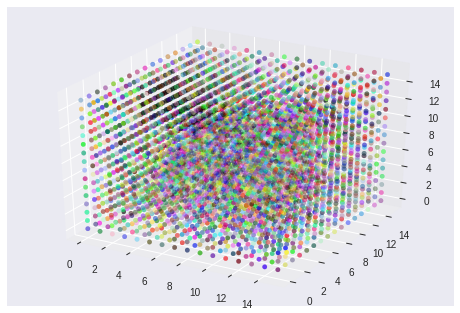

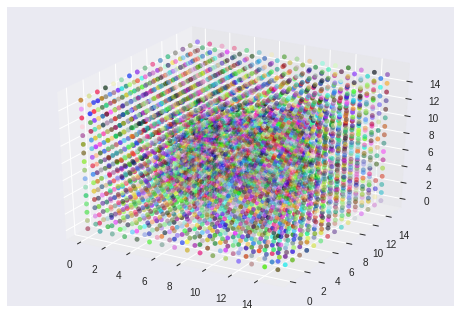

In [0]:
# VISUALIZE THE DATA
# This section displays two examples: one with a "crack" and one without
# This section is solely for visualization purposes and does not affect the rest of the program
from mpl_toolkits.mplot3d import Axes3D

def plot3DImage(img):
  # print(img.shape)
  l, w, h, channels = img.shape
  data = np.zeros((l*w*h, channels))
  for x in range(l):
    for y in range(w):
      for z in range(h):
        index = z*l*w + y*l + x
        data[index] = img[x, y, z]/float(255)
        
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  xv = np.arange(l)
  yv = np.arange(w)
  zv = np.arange(h)
  x, y, z = np.meshgrid(xv, yv, zv)
  ax.scatter(x, y, z, c = data)
  
crackedFound = False
uncrackedFound = False
for i in range(x_train.shape[0]):
  if y_train[i] == 1 and not crackedFound:
    crackedFound = True
    plot3DImage(x_train[i])
  elif y_train[i] == 0 and not uncrackedFound:
    uncrackedFound = True
    plot3DImage(x_train[i])
  if crackedFound and uncrackedFound:
    break



In [0]:
# SET UP CONVNET
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv3D
from keras.layers import MaxPooling3D
from keras.layers import Flatten
from keras.layers import Dense

# convert y data to categorical (one-hot-notation)
import keras
allTruth_categorical = keras.utils.to_categorical(allTruth, 2)

# Initializing the CNN
classifier = Sequential()

# The architecture consists of two Conv3D layer and a fully connected layer, as well as intermediate steps (flatten, pool, etc.)

# LAYER 1:

# Convolution
# make 16 feature detectors with a size of 3x3
# choose the input-image's format to be 256x256x256 with 5 channels (IRGBA)
img_length = 16
img_width = 16
img_height = 16
num_channels = 5
classifier.add(Conv3D(16, (3, 3, 3), input_shape=(img_length, img_width, img_height, num_channels), activation="relu"))

# LAYERS 2-7:

# Convolution
classifier.add(Conv3D(16, (3, 3, 3), activation = 'relu'))
classifier.add(Dropout(0.5))
classifier.add(Conv3D(16, (3, 3, 3), activation = 'relu'))
classifier.add(Dropout(0.5))
classifier.add(Conv3D(16, (3, 3, 3), activation = 'relu'))
classifier.add(Dropout(0.5))
classifier.add(Conv3D(16, (3, 3, 3), activation = 'relu'))
classifier.add(Dropout(0.5))
classifier.add(Conv3D(16, (3, 3, 3), activation = 'relu'))
classifier.add(Dropout(0.5))
classifier.add(Conv3D(16, (3, 3, 3), activation = 'relu'))
classifier.add(Dropout(0.5))

# Max pool
classifier.add(MaxPooling3D(pool_size = (2, 2, 2)))

# LAYER 8

classifier.add(Flatten())

# Full connection
classifier.add(Dense(activation="relu", units=128))

# OUTPUT LAYER

classifier.add(Dense(2, activation="sigmoid"))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# TRAIN DATA AND EVALUATE ON TEST SET

# Train data
classifier.fit(allExamples, allTruth_categorical, epochs = 5, batch_size = 64, verbose = 1, validation_split = 0.15)

In [0]:
classifier.save("/content/gdrive/Team Drives/Crack Detection ConvNet/crack3.h5")

In [0]:
allTruth = np.load("/content/gdrive/Team Drives/Crack Detection ConvNet/allTruth.npy")
allExamples = np.load("/content/gdrive/Team Drives/Crack Detection ConvNet/allExamples.npy")

allcrackedexamples = np.zeros((408, 16, 16, 16, 5))
counter = 0
for i in range(allExamples.shape[0]):
  if allTruth[i] == 1:
    # cracked example
    allcrackedexamples[counter] = allExamples[i]
    counter += 1
print(allcrackedexamples.shape)
np.save("/content/gdrive/Team Drives/Crack Detection ConvNet/allCracked.npy", allcrackedexamples)

(408, 16, 16, 16, 5)


In [0]:
from keras.models import load_model
classifier = load_model ("/content/gdrive/Team Drives/Crack Detection ConvNet/crack3.h5")
crackpredicts = classifier.predict(allcrackedexamples, batch_size=1, verbose=1)

408/408 [==============================] - 4s 11ms/step


In [0]:
def countCrack(crackpredicts):  
  numCorrect = 0
  for i in range(crackpredicts.shape[0]):
    """
    if i < 10:
      print(crackpredicts[i][0])
      print(crackpredicts[i][1])
      print(crackpredicts[i])
    """
    if crackpredicts[i][0] < crackpredicts[i][1]:
      numCorrect += 1
  print(numCorrect)

In [0]:
# allpredicts = classifier.predict(allExamples, batch_size=1, verbose=1)
countCrack(allpredicts)

0.88794535
0.11229239
[0.88794535 0.11229239]
0.8836218
0.11655214
[0.8836218  0.11655214]
0.8840771
0.11610196
[0.8840771  0.11610196]
0.8841146
0.11605967
[0.8841146  0.11605967]
0.8841507
0.11602673
[0.8841507  0.11602673]
0.88412535
0.116048224
[0.88412535 0.11604822]
0.8858062
0.11439698
[0.8858062  0.11439698]
0.88428295
0.11590131
[0.88428295 0.11590131]
0.88860536
0.11159953
[0.88860536 0.11159953]
0.8865561
0.1137392
[0.8865561 0.1137392]
0


In [0]:
#Create a sample with much less uncracked examples
i = 0
j = 0
stopAt = 408
lessExamples = np.zeros((stopAt, 16, 16, 16, 5))
lessTruth = np.zeros((stopAt,))

while i <= stopAt-1:
  index = random.randint(0,allExamples.shape[0]-1)
  if allTruth[index] == 0:
    lessExamples[i] = allExamples[index]
    # lessTruth[i] = # lessTruth is already initialized to a zero vector
    i += 1
    
print (lessExamples.shape[0], len(lessTruth))
lessExamples = np.append(lessExamples, allcrackedexamples, axis=0)
lessTruth = np.append(lessTruth, np.ones((408,)))

print(lessExamples.shape)
print(lessTruth.shape)

408 408
(816, 16, 16, 16, 5)
(816,)


In [0]:
# SET UP CONVNET for SMALL SAMPLES
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv3D
from keras.layers import MaxPooling3D
from keras.layers import Flatten
from keras.layers import Dense
from keras import backend as K
from keras.callbacks import EarlyStopping, Callback
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
from keras.models import Sequential, model_from_json
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense

# segregate validation data manually
totalExamples = lessExamples.shape[0]
print(lessExamples.shape)
numValidation = 81
validationExamples = np.zeros((numValidation, 16, 16, 16, 5))
validationTruth = np.zeros((numValidation,))
trainingExamples = np.zeros((totalExamples - numValidation, 16, 16, 16, 5))
trainingTruth = np.zeros((totalExamples - numValidation,))
validationSetIndices = set()
i = 0
while i < numValidation:
  ind = random.randint(0, totalExamples-1) # python random generator is inclusive
  if ind not in validationSetIndices:
    validationExamples[i] = lessExamples[ind]
    validationTruth[i] = lessTruth[ind]
    validationSetIndices.add(ind)
    i += 1
j = 0
for i in range(totalExamples):
  if i not in validationSetIndices:
    trainingExamples[j] = lessExamples[i]
    trainingTruth[j] = lessTruth[i]
    j += 1
print(validationExamples.shape)
print(validationTruth.shape)
print(trainingExamples.shape)
print(trainingTruth.shape)
  
  

# convert y data to categorical (one-hot-notation)
import keras
trainingTruth_categorical = keras.utils.to_categorical(trainingTruth, 2)
validationTruth_categorical = keras.utils.to_categorical(validationTruth, 2)

# Initializing the CNN
classifierless = Sequential()

# The architecture consists of two Conv3D layer and a fully connected layer, as well as intermediate steps (flatten, pool, etc.)

# LAYER 1:

# Convolution
# make 16 feature detectors with a size of 3x3
# choose the input-image's format to be 256x256x256 with 5 channels (IRGBA)
img_length = 16
img_width = 16
img_height = 16
num_channels = 5
classifierless.add(Conv3D(16, (3, 3, 3), input_shape=(img_length, img_width, img_height, num_channels), activation="relu"))

# LAYERS 2-7:

# Convolution
"""
classifierless.add(Conv3D(16, (3, 3, 3), activation = 'relu'))
# classifierless.add(Dropout(0.5))
classifierless.add(Conv3D(16, (3, 3, 3), activation = 'relu'))
# classifierless.add(Dropout(0.5))
classifierless.add(Conv3D(16, (3, 3, 3), activation = 'relu'))
# classifierless.add(Dropout(0.5))
classifierless.add(Conv3D(16, (3, 3, 3), activation = 'relu'))
# classifierless.add(Dropout(0.5))
classifierless.add(Conv3D(16, (3, 3, 3), activation = 'relu'))
# classifierless.add(Dropout(0.5))
classifierless.add(Conv3D(16, (3, 3, 3), activation = 'relu'))
# classifierless.add(Dropout(0.5))
"""

# Max pool
# classifierless.add(MaxPooling3D(pool_size = (2, 2, 2)))

# LAYER 8

classifierless.add(Flatten())

# Full connection
classifierless.add(Dense(activation="relu", units=16))
classifierless.add(Dense(activation="relu", units=16))
classifierless.add(Dense(activation="relu", units=16))
classifierless.add(Dense(activation="relu", units=16))
classifierless.add(Dense(activation="relu", units=16))
classifierless.add(Dense(activation="relu", units=16))
classifierless.add(Dense(activation="relu", units=16))
classifierless.add(Dense(activation="relu", units=16))
classifierless.add(Dense(activation="relu", units=16))
classifierless.add(Dense(activation="relu", units=16))

# OUTPUT LAYER

classifierless.add(Dense(2, activation="sigmoid"))

# Compiling the CNN
classifierless.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# TRAIN DATA AND EVALUATE ON TEST SET

# Train data
classifierless.fit(trainingExamples, trainingTruth_categorical, epochs = 50, batch_size = 1, verbose = 1, validation_split = 0)
print(classifierless.evaluate(validationExamples, validationTruth_categorical, batch_size = 1, verbose = 1))
classifierless.save("/content/gdrive/Team Drives/Crack Detection ConvNet/crack3_fullyconnected_V1.h5")

Using TensorFlow backend.


NameError: ignored

In [0]:
from keras.models import load_model
classifierless = load_model ("/content/gdrive/Team Drives/Crack Detection ConvNet/crack3_less.h5")
lesscrackpredicts = classifierless.predict(allcrackedexamples, batch_size=1, verbose=1)
countCrack(lesscrackpredicts)

408/408 [==============================] - 2s 5ms/step
0
